<a href="https://colab.research.google.com/github/shreyasat27/pennylane-27524/blob/main/Photonic_quantum_computers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 45.2 MB/s eta 0:00:00


In [6]:
# Import some libraries for a nicer plot
from scipy.stats import gaussian_kde
from numpy import vstack as vstack

In [2]:
#define the device
dev = qml.device("default.gaussian", wires=1, shots=1000)


In photonics devices, wire = qumodes (they are not two-level system in general, so we take infinity superposition of basis states to represent their quantum)

how the measured values of position and momentum are distributed in the x-p space (phase space)

The initial state in default.gaussian is the vacuum so the circuits to measure the quadratures need not contain any operations, except for measurements! We plot 1000 measurement results for both x and p.

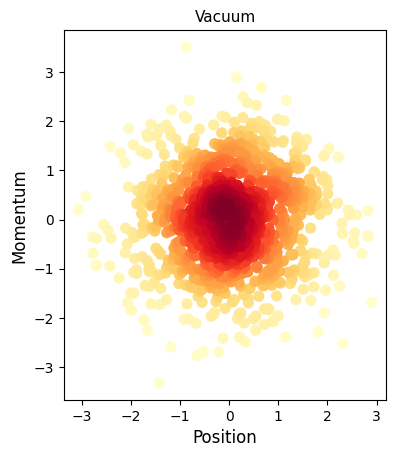

In [12]:
@qml.qnode(dev)
def vacuum_measure_x():
  return qml.sample(qml.QuadX(0)) #sample X quadratures

@qml.qnode(dev)
def vacuum_measure_p():
  return qml.sample(qml.QuadP(0)) #sample p quadratures

#sample measurement in phase space

x_sample = vacuum_measure_x()
p_sample = vacuum_measure_p()

#point density calculation
xp = vstack([x_sample, p_sample])
z = gaussian_kde(xp)(xp)

#sort the points by density
sorted = z.argsort()
x,y,z = x_sample[sorted], p_sample[sorted], z[sorted]

#make the plot
fig, ax = plt.subplots()
ax.scatter(x,y,c = z, s= 50, cmap ="YlOrRd")
plt.title("Vacuum", fontsize =11)
ax.set_ylabel("Momentum", fontsize =12)
ax.set_xlabel('Position', fontsize =12)
ax.set_aspect("equal", adjustable = "box")
plt.show()



In [13]:
dev_exact = qml.device("default.gaussian", wires=1)  # No explicit shots gives analytic calculations


@qml.qnode(dev_exact)
def vacuum_mean_x():
    return qml.expval(qml.QuadX(0))  # Returns exact expecation value of x


@qml.qnode(dev_exact)
def vacuum_mean_p():
    return qml.expval(qml.QuadP(0))  # Returns exact expectation value of p


@qml.qnode(dev_exact)
def vacuum_var_x():
    return qml.var(qml.QuadX(0))  # Returns exact variance of x


@qml.qnode(dev_exact)
def vacuum_var_p():
    return qml.var(qml.QuadP(0))  # Returns exact variance of p


# Print calculated statistical quantities
print("Expectation value of x-quadrature: {}".format(vacuum_mean_x()))
print("Expectation value of p-quadrature: {}".format(vacuum_mean_p()))
print("Variance of x-quadrature: {}".format(vacuum_var_x()))
print("Variance of p-quadrature: {}".format(vacuum_var_p()))

Expectation value of x-quadrature: 0.0
Expectation value of p-quadrature: 0.0
Variance of x-quadrature: 1.0
Variance of p-quadrature: 1.0


What other Gaussian states are there? The states produced by lasers are called coherent states, which are also Gaussian with  
Δx=Δp=1.
  
Coherent states, in general, can have non-zero expectation values for the quadratures (i.e., they are not centered around the origin).

The default.gaussian device allows for the easy preparation of coherent states through the function

A photonic system is said to be in a Gaussian state if its Wigner function is a two-dimensional Gaussian function

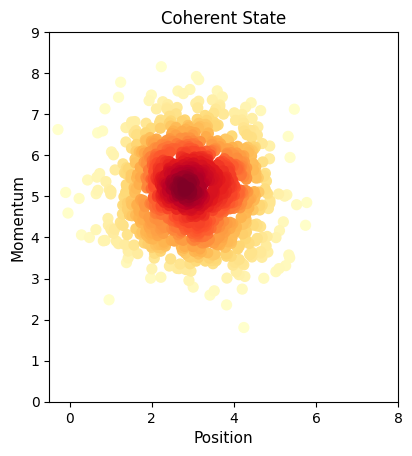

In [16]:
@qml.qnode(dev)
def measure_coherent_x(alpha, phi):
    qml.CoherentState(alpha, phi, wires=0) #it prepares coherent states
    return qml.sample(qml.QuadX(0)) #measure X quadrature

@qml.qnode(dev)
def measure_coherent_p(alpha, phi):
    qml.CoherentState(alpha, phi, wires=0) #prepares coherent states
    return qml.sample(qml.QuadP(0)) #measure P quadrature

#choosing alpha and phi samples for 1000 measurements

x_sample_coherent = measure_coherent_x(3,np.pi/3)
p_sample_coherent = measure_coherent_p(3, np.pi/3)

# Plot as before
xp = vstack([x_sample_coherent, p_sample_coherent])
z1 = gaussian_kde(xp)(xp)

sorted = z1.argsort()
x,y,z = x_sample_coherent[sorted], p_sample_coherent[sorted], z1[sorted]

fig, ax1 = plt.subplots()
ax1.scatter(x,y,c = z, s=50, cmap ="YlOrRd")
ax1.set_title("Coherent State", fontsize=12)
ax1.set_ylabel("Momentum", fontsize=11)
ax1.set_xlabel("Position", fontsize=11)
ax1.set_aspect("equal", adjustable ='box')
plt.xlim([-0.5,8])
plt.ylim([0,9])
plt.show()